<div class="alert alert-block alert-info">
    NOTE: This notebook takes approximately <strong>61 minutes</strong> run.
</div>
<h1 align="center"> Data Science Challenge </h1>


<h2>Task</h2>

We have the transactions below with fraud labeling. 
We need your help to analyze the data and build fraud detection model.
We expect you to do the following dasks:
* Analyze the data as your data science daily job and help us to find critical insights for fraud detection.
* Build and evaluate some machine learning models, and explain how and why you do this.
* Share some thoughts about how you plan do the realtime inference for production env in the cloud. What is your consideration for trade-off. 
* EXTRA: Any interesting thing you learn from the data

In [76]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import haversine as hs
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder, RobustScaler
from datetime import date
from sklearn.impute import SimpleImputer
import time

from sklearn.metrics import accuracy_score
random_state = 12

In [2]:


start = time.time()


df = pd.read_csv ('transactionV2.csv')
df.dob = pd.to_datetime(df.dob)
df.trans_date_trans_time = pd.to_datetime(df.trans_date_trans_time)
df.sort_values(by=["cc_num", "unix_time"], inplace = True)


df_fraud = df.loc[df.is_fraud == True]
df_nfraud = df.loc[df.is_fraud == False]
#df.head()

<h2>Outline</h2>

1. [<b>Introduction</b>](#1) <br>
    a. [Understanding credit card fraud](#1a) <br>
    b. [Understanding our data](#1b) <br>
    c. [Initial hypotheses and remarks](#1c) <br>
  
2. [<b>Data Exploration</b>](#2) <br>
    a. [Fraud vs non-fraud distributions](#2a) <br>
    b. [The merchants](#2b) <br>
    c. [Number of transactions per card](#2c) <br>
    d. [Transaction times and locations](#2d) <br>
   

3. [<b>Data Preprocessing</b>](#3) <br>
    a. [Removing, adding, and encoding features](#3a) <br>
    b. [Feature Scaling](#3b) <br>

4. [<b>Models</b>](#4) <br>

5. [<b>Model Evaluation</b>](#5) <br>

6. [<b>Realtime Inference in the Cloud</b>](#6) <br>

7. [<b>Conclusion</b>](#7) <br>


<a id="1"></a>
<h2>1. Introduction</h2>

<a id="1a"></a>
<h3>1a. Understanding credit card fraud</h3>

Not knowing much about credit card (CC) fraud, I decided to do some basic research to gain a better understanding of the problem. CC fraud is: 
<br><br>

<div style="background-color:rgba(0, 0, 0, 0.0470588); text-align:center; vertical-align: middle; padding:10px 0;">
<em>the unauthorized use of a credit or debit card, or similar payment tool to fraudulently obtain money or property. </em>
</div> <br>

The U.S. holds a large percentage of all the CC fraud incidents in the world which costs billions in losses each year. Credit and debit card numbers can be stolen from unsecured websites or can be obtained in an identity theft scheme. This can occur when:
* purchasing from fraudulent or illegitimate websites
* purchasing from websites with security vulnerabilities
* credit cards are physically stolen or lost
* credit cards are used on skimmers
* through scams, phishing, etc.

Generally, different CC companies have different systems for detecting and preventing fraud. The median loss is \\$311, however the median loss for people over 60 was much higher per FTC. In addition, the most common reported loss amount was \\$1-100 and fraudulent shopping is more likely to occur in certain shopping categories such as jewelry, computer equipment, men’s clothing, and shoes.

There is also a clear discrepancy in the distribution of fraud incidents by state: <br>
<p style="text-align:center;">
<a href="https://mint.intuit.com/blog/planning/credit-card-fraud-statistics/#:~:text=Key%20Credit%20Card%20Theft%20Findings&text=In%20identity%20theft%20cases%2C%20people,2019%20to%20393%2C207%20in%202020.">
<img src = "https://blog.mint.com/wp-content/uploads/2021/06/most-dangerous-states-fraud-identity-theft.png"
  width= "500"
  height= "auto"
  align= "center"></img>
</a>
</p>

Finally, with some basic research and reasoning, I believe some common signs of credit card fraud might include: <br>
* purchases that were made close in time but in distant locations
* orders much larger than usual
* same address on multiple cards on different orders
* one card used to purchase things delivered to multiple addresses
* purchases that deviate from the user’s typical profile
* large purchases right after small purchases
    * fraudsters use small purchases as a test, and then buy larger items many purchases in a short amount of time




<a id="1b"></a>
<h3>1b. Understanding our data </h3>

Let's see the schema of our data

In [3]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90767 entries, 49590 to 26316
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             90767 non-null  int64         
 1   trans_date_trans_time  90767 non-null  datetime64[ns]
 2   cc_num                 90767 non-null  int64         
 3   merchant               90767 non-null  object        
 4   category               90767 non-null  object        
 5   amt                    90767 non-null  float64       
 6   first                  90767 non-null  object        
 7   last                   90767 non-null  object        
 8   gender                 90767 non-null  object        
 9   street                 90767 non-null  object        
 10  city                   90767 non-null  object        
 11  state                  90767 non-null  object        
 12  zip                    90767 non-null  int64         
 1

Some other information about our dataset

In [4]:
print('\t categories:\n\t\t', "\n\t\t".join(df.category.unique()))
print("\t dimensions:\t", df.shape)
print("\t % Fraud Transactions:\t", round(df_fraud.shape[0] / df.shape[0] * 100, 3))
print("\t # Merchants:\t", df.merchant.nunique())
print("\t # CC's:\t", df.cc_num.nunique())

hasFraud = df.groupby("cc_num").apply(lambda g: g.is_fraud.any())
hasNoFraud = df.groupby("cc_num").apply(lambda g: not g.is_fraud.any())

print("\t # CC's with fraud:\t", sum(hasFraud))
print("\t # CC's with no fraud :\t", sum(hasNoFraud))

	 categories:
		 home
		food_dining
		travel
		gas_transport
		health_fitness
		entertainment
		grocery_pos
		misc_pos
		personal_care
		shopping_net
		shopping_pos
		misc_net
		grocery_net
		kids_pets
	 dimensions:	 (90767, 23)
	 % Fraud Transactions:	 1.964
	 # Merchants:	 693
	 # CC's:	 944
	 # CC's with fraud:	 713
	 # CC's with no fraud :	 231


- Luckily, this is a clean dataset (no nulls or invalid values).
<br>
- It looks like we have a dataset with \~90k transactions and 23 features about the cardholder and transaction.
<br>

- The percentage of fradulent transactions is very low (\~%1.9) but the percentage of credit cards with at least 1 fraud transaction is actually quite high (\~%75).
<br>



<a id="1c"></a>
<h3>1c. Initial hypotheses and remarks</h3>

Based on my preliminary research, I'll attempt to make some hypotheses about detecting fraud:
<ol>
    <li> Fraud and non-fraud transactions have different distributions by category and amount </li>
    <li> Cards with more purchases are more likely to have fraud </li>
    <li> Some merchants are sources of fraud </li>
    <li> Fraud varies by age (older people more likely to be victims) </li>
    <li> Fraud varies by location </li>
    <li> CC's with multiple address are more likely to have fraud </li>
    <li> CC transactions with close times at different locations are probably fraud </li>
</ol>

Some other notable remarks:

<ol>
    <li> I hope to find some major discrepancies in fraud/non-fraud transactions, but if not, it may be better detect fraud based on the cardholder's user pattern. </li><br>
    <li> Since the % of fraud transactions is very low, I may consider balancing the dataset by undersampling/oversampling to help prevent overfitting to non-fraud transactions. </li><br>
    <li> Since the dataset is unbalanced, most models will naturally have a high true negative rate for detecting non fraudulent transactions. However in this scenario, I believe that it's more important to have a low false negative rate where a false negative means that a fraudulent transaction was not detected. Since we are building a fraud detection system, our primary goal is to reduce false negatives, but false positives are still problematic since we wouldn't want customers to get their cards declined when trying to make purchases.</li><br>
    
</ol>

<a id="2"></a>
<h2>2. Data Exploration</h2>

<a id="2a"></a>
<h3>2a. Fraud vs non-fraud distributions</h3>

From the box-and-whisker plots, it appears that both transactions have roughly the same median, 1st and 3rd quarters, and outlier ranges.

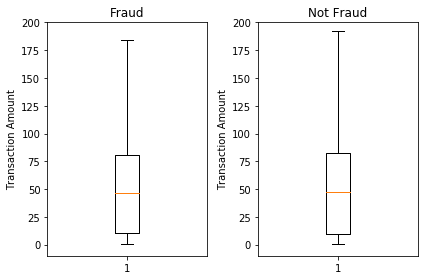

In [5]:
fig, axes = plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.title("Fraud")
plt.ylabel("Transaction Amount")
plt.ylim([-10, 200])
plt.boxplot(df_fraud.amt, showfliers=False);

plt.subplot(1, 2, 2)
plt.title("Not Fraud")
plt.ylabel("Transaction Amount")
plt.ylim([-10, 200])
plt.boxplot(df_nfraud.amt, showfliers=False);

fig.tight_layout()

Below, we see how the number of transactions in each category varies between fraud and non-fraud transactions. The percentage of total transactions by category doesn't differ much between fraud and non-fraud. There are some slight category discrepancies such as in "gas_transport" and "home" but overall not much difference.

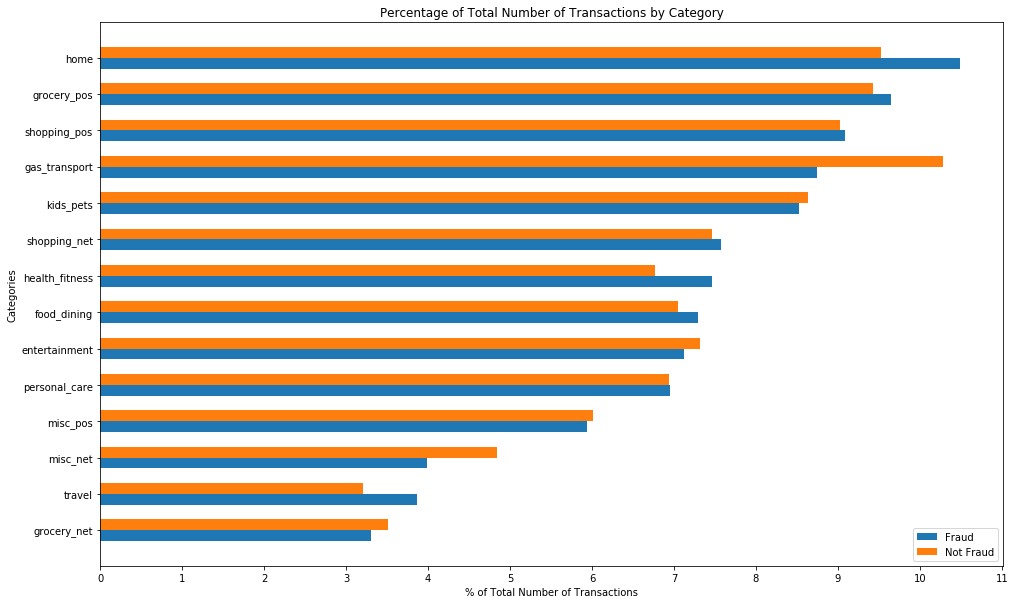

In [6]:
fraud_cat = df_fraud.category.value_counts(ascending = True) / len(df_fraud) * 100
nfraud_cat = df_nfraud.category.value_counts() / len(df_nfraud) * 100
nfraud_cat = [nfraud_cat[cat] for cat in fraud_cat.index]

y = np.arange(len(fraud_cat))
width = 0.3

fig, ax = plt.subplots()
ax.barh(y - width/2, fraud_cat, width, label = "Fraud")
ax.barh(y + width/2, nfraud_cat, width, label = "Not Fraud")

ax.set_yticks(y)
ax.set_yticklabels(fraud_cat.index)

ax.set_xticks(np.arange(12))
ax.legend();

ax.set_title("Percentage of Total Number of Transactions by Category")
ax.set_ylabel("Categories")
ax.set_xlabel("% of Total Number of Transactions")
fig.set_size_inches(16.18, 10)


Similar to above, below we see how the amount spent in each category varies between fraud and non-fraud transactions. Again, there are a few discrepancies but overall the distributions are pretty similar. 

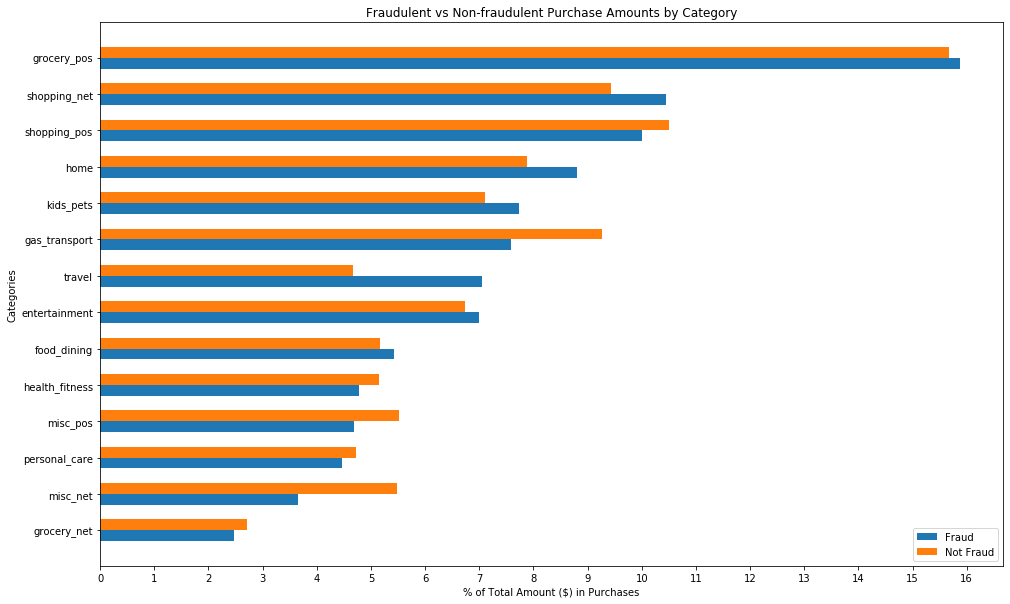

In [7]:
fraud_amt = df_fraud.groupby("category").apply(lambda g: sum(g.amt)).sort_values(ascending = True) / sum(df_fraud.amt) * 100
nfraud_amt = df_nfraud.groupby("category").apply(lambda g: sum(g.amt)) / sum(df_nfraud.amt) * 100

nfraud_amt = [nfraud_amt[cat] for cat in fraud_amt.index]

y = np.arange(len(fraud_amt))
width = 0.3

fig, ax = plt.subplots()
ax.barh(y - width/2, fraud_amt, width, label = "Fraud")
ax.barh(y + width/2, nfraud_amt, width, label = "Not Fraud")

ax.set_yticks(y)
ax.set_yticklabels(fraud_amt.index)

ax.set_xticks(np.arange(17))
ax.legend();

ax.set_title("Fraudulent vs Non-fraudulent Purchase Amounts by Category")
ax.set_ylabel("Categories")
ax.set_xlabel("% of Total Amount ($) in Purchases")
fig.set_size_inches(16.18, 10)

Below, I used Tableau to visualize the how many transactions are registered to each state which is determined by the transaction's credit card address. We see that normal and fraudulent purchases have similar distributions. High population states like Texas, Pennsylvania, New York, and California have more transactions, while low population states in the moutain west region have fewer.  

Since they have similar distributions, this means that the probability of CC fraud is roughly proportional to the population size. This probably isn't too surprising, since it means that higher population results in more fraud, but this does confirm that credit card fraud is roughly I.I.D. with population size (i.e. credit card scammers aren't generally targeting any particular state).

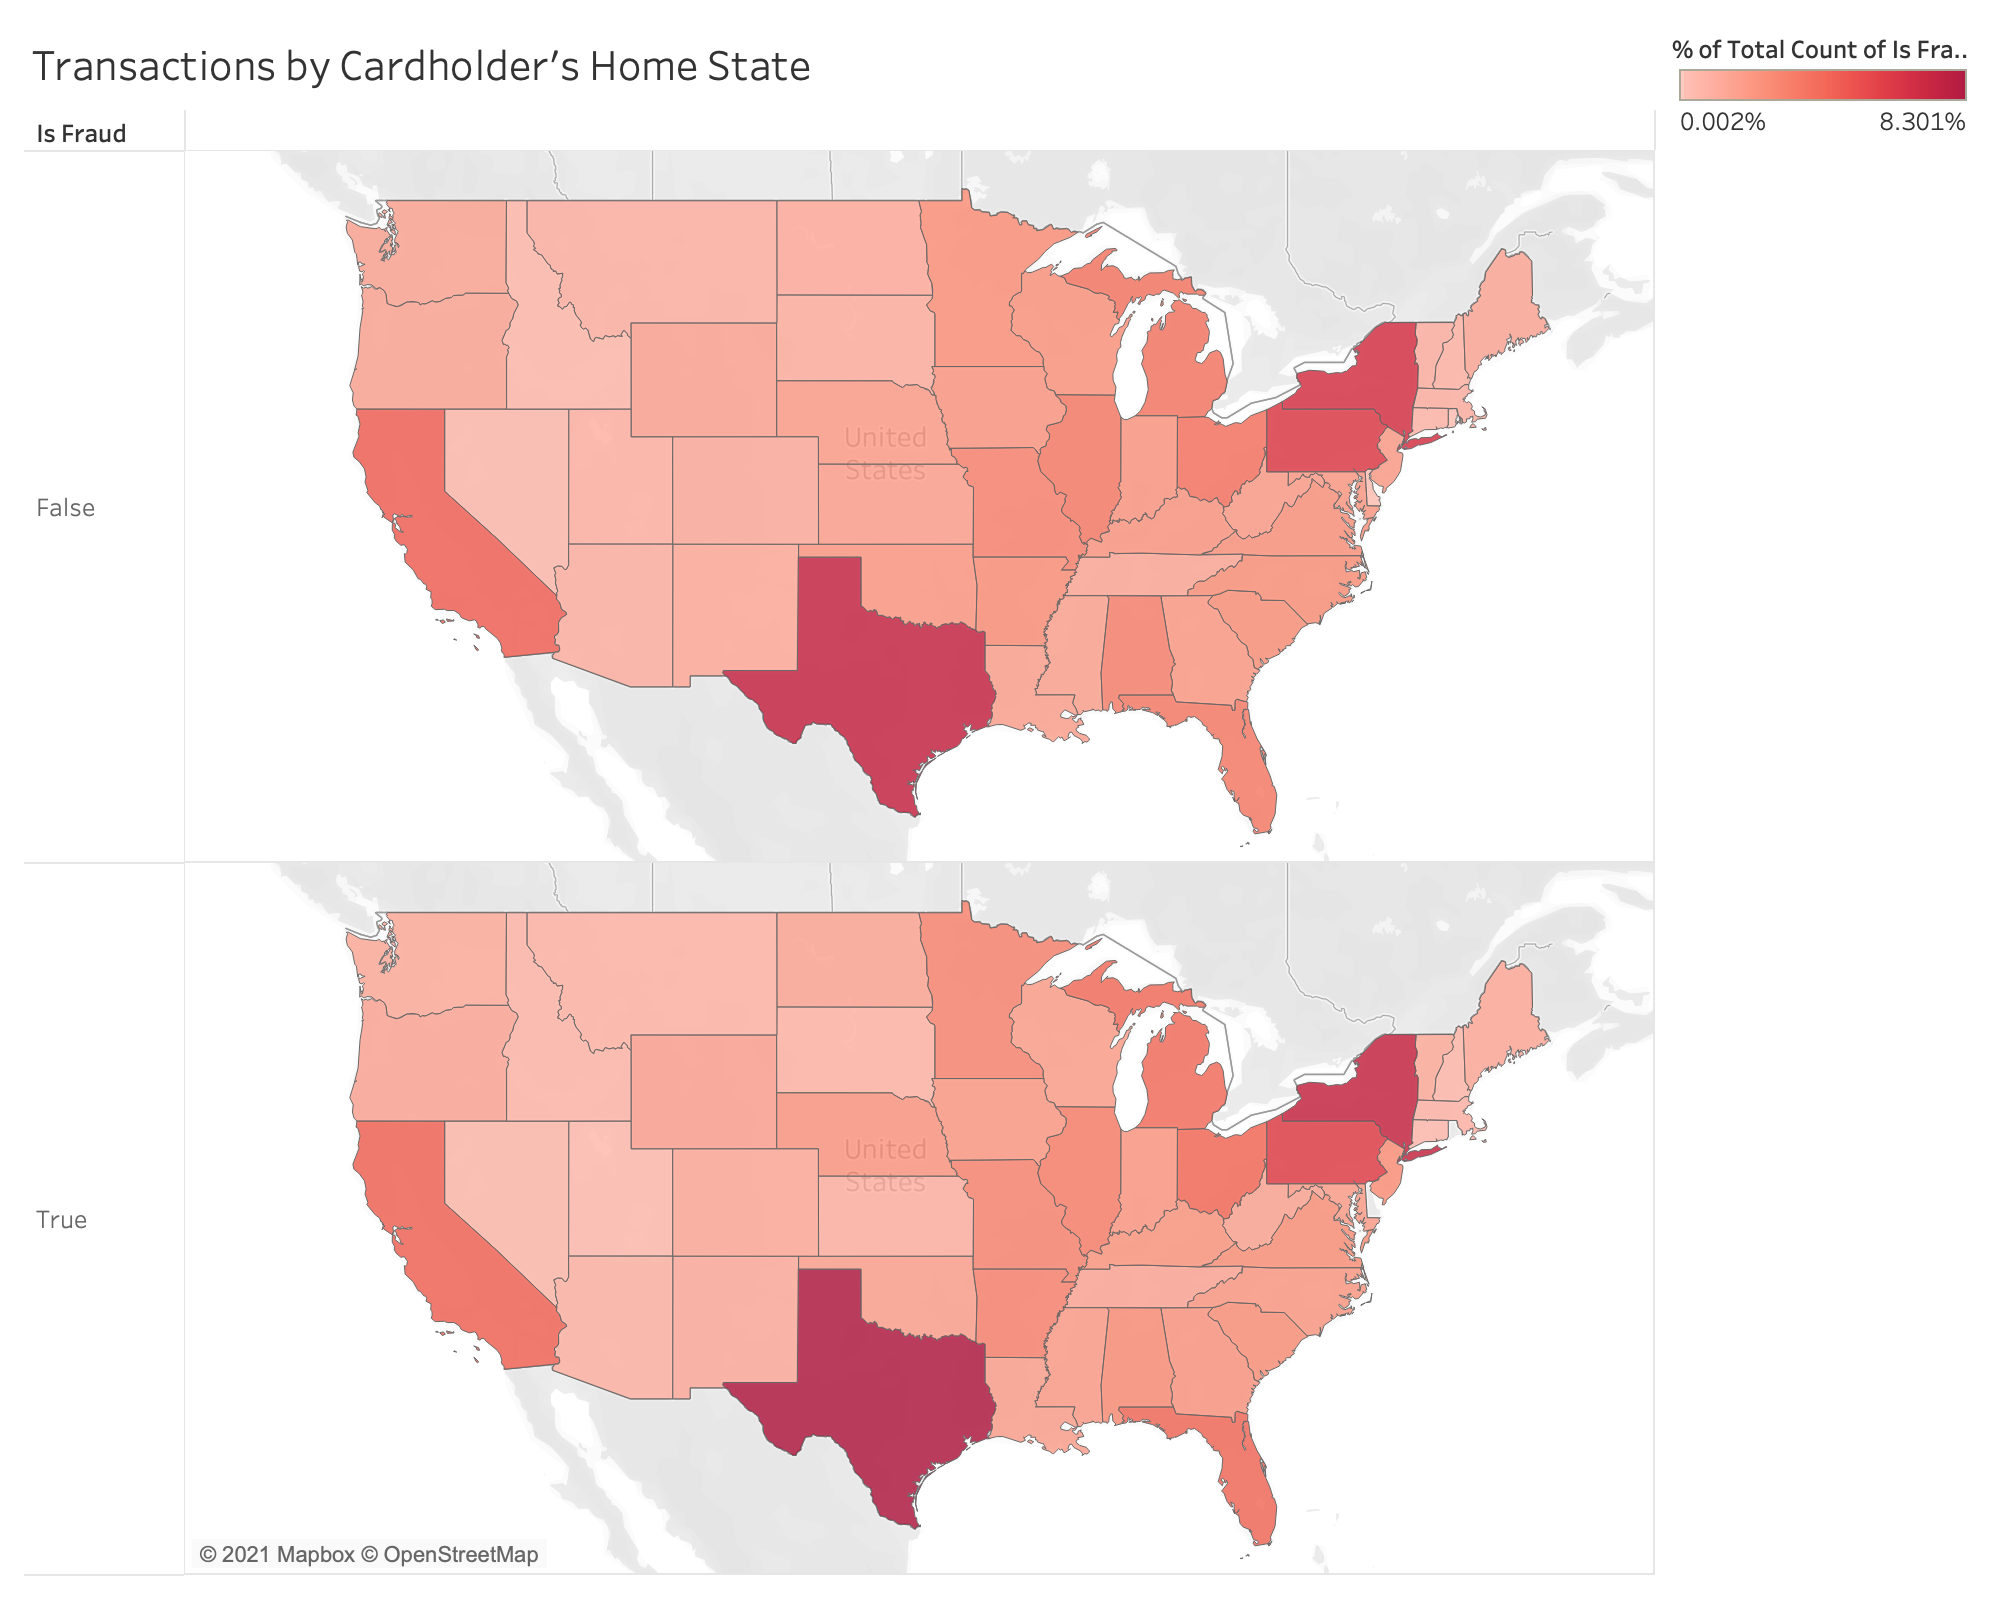



Finally I compared the number of transactions by the cardholder's year of birth (YOB). Again we see that the number of both fraud and non-fraud transactions are similary distributed. Both have a skewed bimodal distribution with a dip around 1980. If you look at the U.S. population distribution by age, it also follows a similar pattern which means that transactions are roughly I.I.D. with population age.

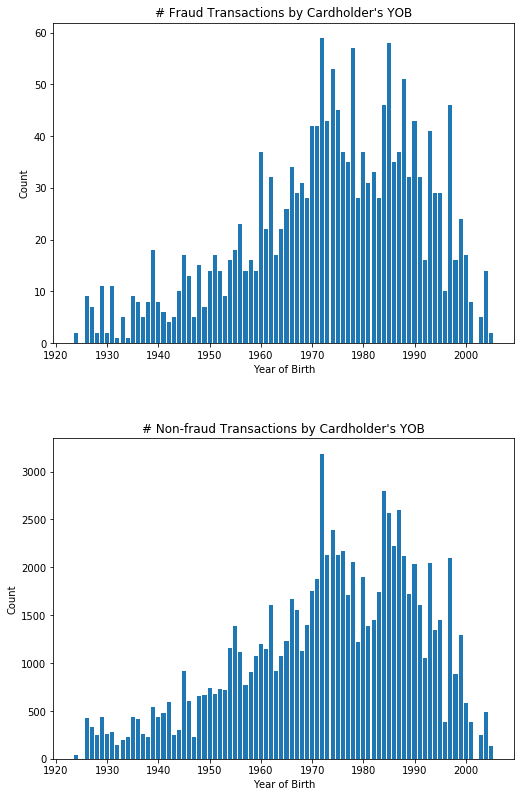

In [8]:
years = df_fraud.dob.apply(lambda d: d.year)
yearCounts = years.groupby(years).count()

fig, axes = plt.subplots(2, 1)
fig.tight_layout()
fig.set_size_inches(7.41, 12)

plt.subplot(2,1,1)
plt.bar(yearCounts.index, yearCounts)
plt.title("# Fraud Transactions by Cardholder's YOB")
plt.xlabel("Year of Birth")
plt.ylabel("Count")

years = df_nfraud.dob.apply(lambda d: d.year)
yearCounts = years.groupby(years).count()

plt.subplot(2,1,2)
plt.bar(yearCounts.index, yearCounts)
plt.title("# Non-fraud Transactions by Cardholder's YOB")
plt.xlabel("Year of Birth")
plt.ylabel("Count");



<a id="2b"></a>
<h3>2b. The merchants </h3>

Here I simply found the percent of fraudulent transactions for each merchant. This table is just a sample but it clearly shows major differences among the merchants. I'll most likely use this percentage as a feature which will hopefully act as a prior probability.

In [9]:
fraudCountsByMerch = df_fraud.groupby("merchant").merchant.count()
countsByMerch = df.groupby("merchant").merchant.count()
fraudPercentByMerch = [fraudCountsByMerch[merch] / countsByMerch[merch] * 100 for merch in fraudCountsByMerch.index]

df_merch = pd.DataFrame(fraudPercentByMerch, index=fraudCountsByMerch.index)
df_merch.rename(columns={0:"percent_fraud"}, inplace=True)
df_merch.sort_values(by="percent_fraud", ascending = False)

,percent_fraud
merchant,
"fraud_Monahan, Hermann and Johns",7.142857
fraud_Lynch-Mohr,6.779661
"fraud_Kunze, Larkin and Mayert",6.382979
fraud_Tillman LLC,6.382979
"fraud_Dare, Fritsch and Zboncak",6.106870
...,...
"fraud_Lowe, Dietrich and Erdman",0.546448
fraud_Harris Inc,0.534759
"fraud_Moore, Williamson and Emmerich",0.526316


<a id="2c"></a>
<h3>2c. Number of transactions per card</h3>

Now let's see if high credit card use is correlated with "fraudiness" in any way.

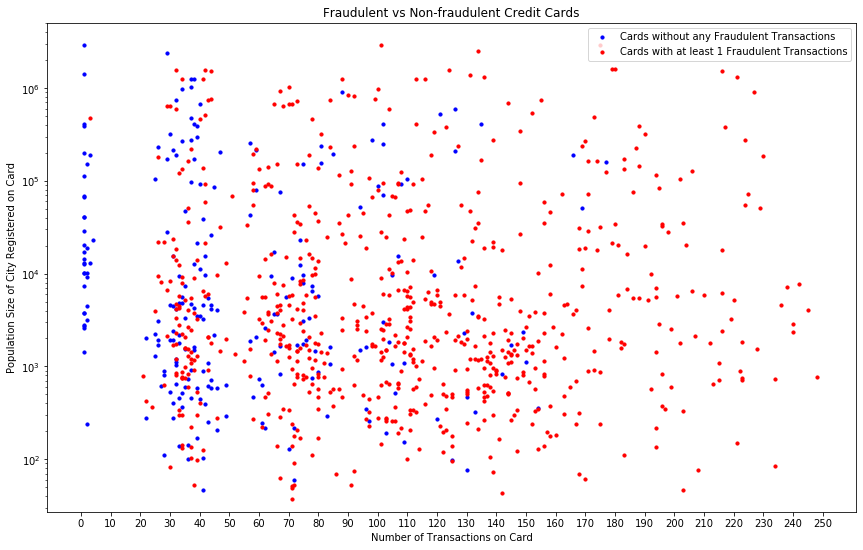

In [10]:
numFraudTransByCC = df_fraud.groupby("cc_num").cc_num.count()
numTransByCC = df.groupby("cc_num").cc_num.count()
cityPopByCC = df.groupby("cc_num").apply(lambda g: g.city_pop.iloc[0])

numFraudTransByCC = df_fraud.groupby("cc_num").cc_num.count()

fraud_cc = df_fraud.cc_num.unique()
fraud_cc_num_trans = [numTransByCC[cc] for cc in fraud_cc]
fraud_cc_citypop = [cityPopByCC[cc] for cc in fraud_cc]
'''
fraud_percent = np.array([numFraudTransByCC[cc] / numTransByCC[cc] * 100 for cc in fraud_cc])
scale_min, scale_max = 10, 100
std = (fraud_percent - min(fraud_percent)) / (max(fraud_percent) - min(fraud_percent))
fraud_percent_scaled = std * (scale_max - scale_min) + scale_min
'''


nfraud_cc = hasNoFraud.loc[hasNoFraud == True].index
nfraud_cc_num_trans = [numTransByCC[cc] for cc in nfraud_cc]
nfraud_cc_citypop = [cityPopByCC[cc] for cc in nfraud_cc]


fig, ax = plt.subplots()


plt.scatter(nfraud_cc_num_trans, nfraud_cc_citypop, c = 'blue', s = 10, label = "Cards without any Fraudulent Transactions")
plt.scatter(fraud_cc_num_trans, fraud_cc_citypop, c = 'red', s = 10, label = "Cards with at least 1 Fraudulent Transactions")

plt.yscale('log')
plt.xticks(np.arange(0, 260, 10))

plt.title("Fraudulent vs Non-fraudulent Credit Cards")
plt.xlabel("Number of Transactions on Card")
plt.ylabel("Population Size of City Registered on Card")
plt.legend()

fig.set_size_inches(14.5, 9)

From the above scatter plot above, we see some patterns. Cards with fewer transactions are more likely to have no fraud and cards with fewer than ~15 transactions are almost all fraudless. In contrast, the vast majority of cards with 150+ transactions have at least 1 fraudulent transaction. Thus, the number of transactions on a card seems like it could be a useful feature, so I'll create a new feature for it called "cc_num_transactions". Also, it appears that most cards are also from cities with relatively low populations (200 - 20,000). 

In [11]:
df["cc_num_transactions"] = df.cc_num.apply(lambda cc: numTransByCC[cc])


<a id="2d"></a>
<h3>2d. Transaction times and locations</h3>

It should make sense that if a credit card was used to buy multiple things in a short time span but in different faraway locations, then that would be a clear sign of fraudulent behavior. However with online shopping, it is possible to quickly buy multiple things from distant merchants. Unfortunately, our dataset doesn't contain information about whether a transaction was online or in-person so it's unclear if time/distances between consecutive transactions will really help out our models. 

Regardless, I created two new features called "unix_time_diff" and "merch_dist_diff" which contains the time difference since the last transaction and the distance from the previous merchant to the current merchant. The first values for each credit card is Null since there is no previous transaction.

Here's a sample of some of the newly added features:

In [12]:
newDF = df.sort_values(by="unix_time").groupby("cc_num")
unix_time_lag = newDF["unix_time"].shift(1)
merch_lat_lag = newDF["merch_lat"].shift(1)
merch_long_lag = newDF["merch_long"].shift(1)

newDF = newDF.obj
newDF["unix_time_lag"] = unix_time_lag
newDF["merch_lat_lag"] = merch_lat_lag
newDF["merch_long_lag"] = merch_long_lag


newDF["unix_time_diff"] = newDF.unix_time - newDF.unix_time_lag
newDF["merch_dist_diff"] = [hs.haversine((lat1, long1), (lat2, long2)) for lat1, long1, lat2, long2 in zip(newDF.merch_lat, newDF.merch_long, newDF.merch_lat_lag, newDF.merch_long_lag)]
df = newDF

In [13]:
df[["cc_num","unix_time", "unix_time_diff", "merch_lat", "merch_long", "merch_dist_diff", "is_fraud"]].loc[df.cc_num == 4452366298769043][35:45]

,cc_num,unix_time,unix_time_diff,merch_lat,merch_long,merch_dist_diff,is_fraud
13288,4452366298769043,1337824295,373873.0,31.255730,-97.369313,88.624725,False
12962,4452366298769043,1337883972,59677.0,32.807908,-96.306129,199.579414,False
72926,4452366298769043,1337956621,72649.0,31.855689,-95.885379,113.020830,False
80476,4452366298769043,1338047446,90825.0,32.580511,-96.820488,119.306884,True
43008,4452366298769043,1338047446,0.0,32.580511,-96.820488,0.000000,True
15282,4452366298769043,1338116913,69467.0,32.254306,-96.916487,37.374945,False
64486,4452366298769043,1338584015,467102.0,32.767162,-97.603487,86.034448,True
76888,4452366298769043,1338584015,0.0,32.767162,-97.603487,0.000000,True
46987,4452366298769043,1338739473,155458.0,31.742670,-97.583586,113.933840,False
44654,4452366298769043,1338879073,139600.0,32.227093,-96.041243,155.115863,False


It appears that some fraudulent transactions occur in pairs at exactly the same time and location...

<a id="3"></a>
<h2>3. Data Preprocessing</h2>

<a id="3a"></a>
<h3>3a. Removing, adding, and encoding features</h3>

Removed features:
- trans_date_trans_time
    - redundant, already have transaction unix time which will be easier to work with
- trans_num
    - some duplicates but these are mostly random id's, I think
- job
    - probably not very useful but may try training models with and without it
- first, last
    - probably not useful however a lot of people may have multiple credit cards so maybe it would be better to group data by people instead of credit cards? We can then distinguish between people with the same names by using their address.
- street, city, zip
    - these are a bit redundant since we already have longitude and latiude
    - I'll keep state as a categorical feature
- dob
    - will most likely convert this to age

Added features:
- age
- unix_time_diff (time since last purchase on credit card, added earlier)
- merch_dist_diff (distance from the previous merchant to the current merchant, added earlier)

Modified features:
- merchant, state, category, cc_num ==> ordinal encoded
    - I know ordinal encoding should generally be used for categories that have some order such as (small, medium, large) but there were too many categories to do onehot encoding.
- gender ==> onehot encoded

Unsure features:
- unix_time
    - Only reason why this would be useful is for ordering the transactions. I tried keeping it anyways.
    
Below is a preview of out newly modified dataset with some features removed and some new features added.

In [14]:
# create a new "age" feature for each person
df["age"] = df.dob.apply(lambda d: date.today().year - d.year)

# ordinal encode categorical features, these probably have too many categories for onehot encoding
df["merchant"] = OrdinalEncoder().fit_transform(np.array(df.merchant).reshape(-1, 1))
df["state"] = OrdinalEncoder().fit_transform(np.array(df.state).reshape(-1, 1))
df["category"] = OrdinalEncoder().fit_transform(np.array(df.category).reshape(-1, 1))
df["cc_num"] = OrdinalEncoder().fit_transform(np.array(df.cc_num).reshape(-1, 1))

df.reset_index(inplace=True)

# onehot encode gender
df["male"] = [df.gender == "M"][0]
df["female"] = [df.gender == "F"][0]




"""
Generally, imputation should be fitted on the training set and then used to transform 
both the training set and test set to avoid data leakage.

But in this case, we're just filling in the values for the first entries
where there is no difference.

Simply imputing a typical value is probably sufficient.

We just need to be able to tell if the differences are either small or big.
"""
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df["unix_time_diff"] = imputer.fit_transform(np.array(df["unix_time_diff"]).reshape(-1,1))
df["merch_dist_diff"] = imputer.fit_transform(np.array(df["merch_dist_diff"]).reshape(-1,1))


# drop columns
df.drop(columns = [
    "Unnamed: 0", \
    'trans_date_trans_time', \
    'trans_num', \
    'first', \
    'last', \
    'street', \
    'city', \
    'zip', \
    'dob', \
    'unix_time_lag', \
    'merch_lat_lag', \
    'merch_long_lag', \
    'job', \
    "dob", \
    "gender", \
    "index", \
    
    "state"], inplace = True)

df.head()

,cc_num,merchant,category,amt,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,cc_num_transactions,unix_time_diff,merch_dist_diff,age,male,female
0,75.0,92.0,2.0,53.60,39.7562,-98.4462,242,1325377849,40.332519,-99.062962,False,167,453443.510838,99.826121,35,False,True
1,149.0,394.0,4.0,212.75,37.9931,-100.9893,2691,1325377935,38.862183,-101.234087,False,150,453443.510838,99.826121,29,False,True
2,771.0,231.0,2.0,48.68,41.0472,-79.8089,139,1325379565,40.237898,-79.894073,False,156,453443.510838,99.826121,68,False,True
3,242.0,514.0,8.0,3.79,40.6152,-74.4150,71485,1325380197,40.813669,-75.283465,False,225,453443.510838,99.826121,48,False,True
4,759.0,585.0,3.0,57.43,40.8295,-72.6473,3255,1325381650,41.669034,-73.271605,False,71,453443.510838,99.826121,44,False,True


<a id="3b"></a>

<h3>3b. Feature Scaling</h3>

Scaling features is almost always helpful for training models. Here I make sure to not scale boolean features. I would've liked to encode "cc_num" but there are too many (944) credit card numbers for onehot encoding and I'm afraid that using any encoding scheme followed by a scaler would downplay the importance of "cc_num" when training the model. Therefore, I feel that I should maybe leave it as is? or scale it on a wider range?

Below is our scaled dataset.

In [26]:
robustScaler = RobustScaler()

# make sure to not scale boolean features
# 'state',
featuresToScale = ['cc_num', 'merchant', 'category', 'amt',  'lat', 'long',
       'city_pop', 'unix_time', 'merch_lat', 'merch_long',
       'cc_num_transactions', 'unix_time_diff', 'merch_dist_diff', 'age']
df_scaled = df.copy()
for feature in featuresToScale:
    df_scaled[feature] = robustScaler.fit_transform(df_scaled[feature].values.reshape(-1,1))
    
# I considered scaling up the cc_num feature so it would have a greater influence for knn models
#df_scaled.cc_num *= 10
df_scaled

,cc_num,merchant,category,amt,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,cc_num_transactions,unix_time_diff,merch_dist_diff,age,male,female
0,-0.839400,-0.731214,-0.571429,0.082415,0.052006,-0.658323,-0.112192,-1.160335,0.129226,-0.698016,False,0.493671,0.416844,0.014370,-0.48,False,True
1,-0.680942,0.141618,-0.285714,2.261209,-0.186402,-0.810947,0.011908,-1.160331,-0.073584,-0.828480,False,0.278481,0.416844,0.014370,-0.72,False,True
2,0.650964,-0.329480,-0.571429,0.015059,0.226576,0.460195,-0.117412,-1.160252,0.116175,0.453844,False,0.354430,0.416844,0.014370,0.84,False,True
3,-0.481799,0.488439,0.285714,-0.599493,0.168161,0.783910,3.497973,-1.160221,0.195593,0.730895,False,1.227848,0.416844,0.014370,0.04,False,True
4,0.625268,0.693642,-0.428571,0.134848,0.197139,0.889998,0.040488,-1.160151,0.313577,0.851788,False,-0.721519,0.416844,0.014370,-0.12,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90762,0.443255,0.280347,-0.285714,1.203778,-0.152651,-2.126788,-0.107378,1.086584,-0.056343,-2.190580,False,0.240506,-0.172099,0.876135,0.84,False,True
90763,0.642398,-0.407514,-0.142857,0.858923,0.866564,-1.420375,0.796899,1.086598,0.755800,-1.432747,False,0.177215,0.659807,-0.788308,0.00,True,False
90764,0.963597,0.332370,-0.714286,-0.512561,1.279353,-1.255466,-0.114726,1.086599,1.239650,-1.269400,False,-0.316456,1.181088,-0.684716,0.44,True,False
90765,0.100642,-0.898844,-0.714286,0.421932,-1.042892,-0.560090,-0.111128,1.086611,-1.184459,-0.539228,False,0.215190,0.887546,1.472075,0.76,False,True


<a id="4"></a>

<h2>4. Models</h2>

Now we'll create some simple classifiers and see how well they work before any optimizations.

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [28]:
classifiers = {
    "log": LogisticRegression(solver = "liblinear"),
    "knn": KNeighborsClassifier(),
    #"svc": SVC(),   # SVC ends up being extremely slow in the later cells so I went ahead and removed this one.
    "rf": RandomForestClassifier()
}

In [21]:
for key, classifier in classifiers.items():
    training_score = cross_val_score(classifier, df_scaled.drop(columns=["is_fraud"]), df_scaled.is_fraud, cv=5)
    print(classifier.__class__.__name__, "cross validation score", round(training_score.mean(), 2) * 100)

LogisticRegression cross validation score 98.0
KNeighborsClassifier cross validation score 98.0
RandomForestClassifier cross validation score 79.0


On the surface, it looks like logistic regression performs the best and is the fastest. This makes sense because logistic regression is good for binary classification. The random forest doesn't perform too well, so I'll go ahead and drop that classifier.

In [33]:
classifiers.pop("rf")


RandomForestClassifier()

<a id="5"></a>

<h2>5. Model Evaluation</h2>

In the following code cells, I do the following:
1. Split the data into a training set (75%) and testing set (25%) using a randomized stratified split in order to maintain the same ratio of labels.
2. For each classifier (log and knn):
    1. Create a GridSearchCV estimator using a custom set of grid parameters for each classifier.
    2. Do a stratified k-fold split on the training data to create a validation set and another subtraining set and for each split:
        1. Randomly upsample the training set's minority class by duplicating samples with replacement. I considered using another sampling strategy like SMOTE and ADASYN but those use interpolation to create new samples. This is problematic when interpolating encoded categorical features like credit card number and gender, because that essentially means that new categories are being created. Another possible way of upsampling is to perform SMOTE on the numerical features and then simply copy over the categorical features.
        2. Fit the GridSearchCV estimator with the upsampled training data
        3. Score the validation set with the fitted estimator
    3. Keep track of the average score and best estimators


In [98]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss

In [31]:
parameters = {
    "log": [{
        "penalty": ['l1', 'l2'],
        "C": [.01, 1, 100],
        "solver": ["liblinear"]}],
    "knn": [{
        "weights": ["uniform", "distance"]}],
    "svc": [{
        "C": [.01, 1, 100],
        "kernel": ['rbf']}]
}

x = np.array(df_scaled.drop(columns=["is_fraud"]))
y = np.array(df_scaled["is_fraud"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)


kfolder = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
best_estimators = collections.defaultdict(list)

for clf in classifiers:
    accuracies = []
    grid_estimator = GridSearchCV(classifiers[clf], parameters[clf])
    
    for train, valid in kfolder.split(x_train, y_train):
        pipeline = imbalanced_make_pipeline(RandomOverSampler(sampling_strategy='minority'), grid_estimator)
        pipeline.fit(x_train[train], y_train[train])
        best_estimators[clf].append(grid_estimator.best_estimator_)
        accuracies.append(pipeline.score(x_train[valid], y_train[valid]))
    print("{clf} accuracy: {mean}".format(clf=clf, mean=round(np.mean(accuracies),2)))


log accuracy: 0.53
knn accuracy: 0.93


KeyError: 'rf'

The results are summarized:
- logistic: ~55%
- knn: ~93%
- svc: N/A, too slow

Yikes that's not too great. It looks like a knn or logistic model trained on the imbalanced training set actually performs better but I have an hypothesis for why knn performs significantly better than logistic when the data is balanced.

In some other credit card fraud detection projects online, they are given a set of anonymous features generated with PCA. I assume these features all continuous and that these features are probably more informative than the ones that I manually created. Since those features aren't categorical, they must contain information about the purchases themselves rather than information about the customer profile.

Our dataset, however, contains about 12 categorical features such as credit card number, first name, gender, street, state, zip code and job. Most of these categorical features contain information about the cardholder rather than the transactions themselves. This suggests that it may be better to use these features to sort of build a customer profiles or to maybe cluster similar profiles instead of trying to learn from the transaction characteristics.

I believe knn outperforms logistic regression in this scenario because knn models are non-parametric models which might make more sense for highly categorical data. By simply finding the closest K neighbors, the knn model, in a sense, retains this vital categorical information.


Since the knn model is performing reasonably well with a 93% average accuracy, I'll use this model as the main classifier from now on. If we look at the list of best knn estimators, they are all distance-based models so we'll assume that distance-based works best. 

In [35]:
best_estimators

defaultdict(list,
            {'log': [LogisticRegression(C=0.01, penalty='l1', solver='liblinear'),
              LogisticRegression(C=100, solver='liblinear'),
              LogisticRegression(C=1, penalty='l1', solver='liblinear'),
              LogisticRegression(C=0.01, penalty='l1', solver='liblinear'),
              LogisticRegression(C=0.01, solver='liblinear')],
             'knn': [KNeighborsClassifier(weights='distance'),
              KNeighborsClassifier(weights='distance'),
              KNeighborsClassifier(weights='distance'),
              KNeighborsClassifier(weights='distance'),
              KNeighborsClassifier(weights='distance')]})

Now let's try doing a grid search on knn models to find the optimal number of neighbors and then we'll use the full training set for training after balancing it.

In [37]:
knn_params =  [{
        "weights": ["distance"],
        "n_neighbors": [5, 10, 15]}]
knn_grid_estimator = GridSearchCV(classifiers["knn"], knn_params)
pipeline = imbalanced_make_pipeline(RandomOverSampler(sampling_strategy='minority'), knn_grid_estimator)
pipeline.fit(x_train, y_train)
pd.DataFrame(knn_grid_estimator.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.119517,0.011240,62.345845,2.210909,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.965884,0.966258,0.965921,0.965622,0.965396,0.965816,0.000292,1
1,0.118727,0.006882,57.933086,0.804872,10,distance,"{'n_neighbors': 10, 'weights': 'distance'}",0.943377,0.942928,0.943302,0.942703,0.943150,0.943092,0.000248,2
2,0.121372,0.011752,59.769772,1.468470,15,distance,"{'n_neighbors': 15, 'weights': 'distance'}",0.918474,0.917987,0.917762,0.916826,0.916336,0.917477,0.000782,3


Okay it looks like the model performs best when we use a knn model with 5 neighbors and distance-based weights. Note that mean accuracy also goes down as the number of neighbors increases.

In [38]:
knn_grid_estimator.best_params_

{'n_neighbors': 5, 'weights': 'distance'}

Now let's do a final test on the test set.

In [39]:
print("KNN Test Accuracy: ", round(knn_grid_estimator.score(x_test, y_test), 2))

KNN Test Accuracy:  0.93


The knn model achieves a test accuracy of ~93% which is not that great. Let's try using a simple neural net for fun and see if it can do better

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Epoch 1/100
126/126 [==============================] - 4s 16ms/step - loss: 0.6272 - binary_accuracy: 0.6576 - val_loss: 0.2639 - val_binary_accuracy: 0.9796
Epoch 2/100
126/126 [==============================] - 2s 15ms/step - loss: 0.4383 - binary_accuracy: 0.8314 - val_loss: 0.1940 - val_binary_accuracy: 0.9796
Epoch 3/100
126/126 [==============================] - 2s 15ms/step - loss: 0.4228 - binary_accuracy: 0.8331 - val_loss: 0.1968 - val_binary_accuracy: 0.9777
Epoch 4/100
126/126 [==============================] - 2s 14ms/step - loss: 0.4105 - binary_accuracy: 0.8341 - val_loss: 0.1899 - val_binary_accuracy: 0.9723
Epoch 5/100
126/126 [==============================] - 2s 15ms/step - loss: 0.3869 - binary_accuracy: 0.8416 - val_loss: 0.1877 - val_binary_accuracy: 0.9684
Epoch 6/100
126/126 [==============================] - 2s 14ms/step - loss: 0.3801 - binary_accuracy: 0.8398 - val_loss: 0.1815 - val_binary_accuracy: 0.9668
Epoch 7/100
126/126 [==============================]

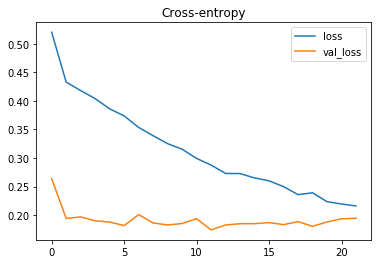

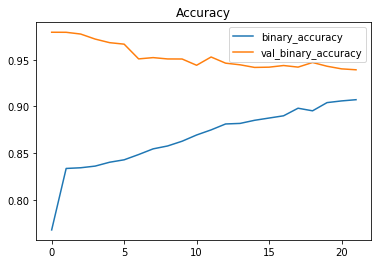

In [94]:
def make_model(input_shape):
    model = keras.Sequential([
        layers.BatchNormalization(input_shape=[input_shape]),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.1),
        
        layers.Dense(256, activation=tf.keras.layers.LeakyReLU()),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.1),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.1),
        
        layers.Dense(128, activation=tf.keras.layers.LeakyReLU()),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.1),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(rate=0.1),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        
        layers.Dense(16, activation=tf.keras.layers.LeakyReLU()),
        
        layers.Dense(1, activation='sigmoid')

    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['binary_accuracy']
    )
    
    return model



early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)



x_not_test, x_test, y_not_test, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)
x_train, x_valid, y_train, y_valid = train_test_split(x_not_test, y_not_test, test_size=0.25, random_state=random_state)

# randomly oversample the minority class so that (# minority)/(# majority) = .2
ros = RandomOverSampler(sampling_strategy=.2, random_state=random_state)
x_train, y_train = ros.fit_resample(x_train, y_train)

x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

x_valid = np.asarray(x_valid).astype('float32')
y_valid = np.asarray(y_valid).astype('float32')

x_test = np.asarray(x_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

model = make_model(x_train.shape[1])
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    batch_size=512,
    epochs=100,
    callbacks=[early_stopping],
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")


It looks like a simple neural net isn't really performing much better than the knn, however I believe the neural net will be better because it is a parametric model and is faster. Next using this neural net model, I'll make the confusion matrices below.

accuracy score:  0.9558774925636223


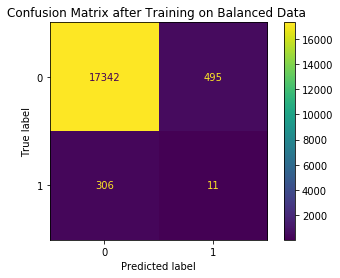

accuracy score:  0.982538283573868


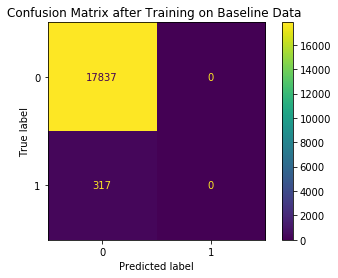

In [97]:
y_pred = model.predict(tf.convert_to_tensor(x_test)) >= .5
print("accuracy score: ", accuracy_score(y_pred, y_test))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix after Training on Balanced Data ")
plt.show()


baseline_x = df.drop(columns=["is_fraud"])
baseline_y = df['is_fraud']
xx_not_test, xx_test, yy_not_test, yy_test = train_test_split(baseline_x, baseline_y, test_size=0.20, random_state=random_state)
xx_train, xx_valid, yy_train, yy_valid = train_test_split(xx_not_test, yy_not_test, test_size=0.25, random_state=random_state)

xx_train = np.asarray(xx_train).astype('float32')
yy_train = np.asarray(yy_train).astype('float32')

xx_valid = np.asarray(xx_valid).astype('float32')
yy_valid = np.asarray(yy_valid).astype('float32')

xx_test = np.asarray(xx_test).astype('float32')
yy_test = np.asarray(yy_test).astype('float32')

model2 = make_model(xx_train.shape[1])
model2.fit(
    xx_train, yy_train,
    validation_data=(xx_valid, yy_valid),
    batch_size=512,
    epochs=100,
    callbacks=[early_stopping],
    verbose=0
)

yy_pred = model2.predict(tf.convert_to_tensor(xx_test)) >= .5
print("accuracy score: ", accuracy_score(yy_pred, yy_test))
cm = confusion_matrix(yy_test, yy_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix after Training on Baseline Data ")
plt.show()

end = time.time()

In [ ]:
knn_model = classifiers["knn"]
knn_model.fit(x_train, y_train)
y_pred = [1.0 if prob>0.5 else 0.0 for prob in knn_model.predict(x_test)]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix after Training on Balanced Data ")
plt.show()

From the top confusion matrix, we see that models trained on balanced data is much less accurate but this is primarily due to higher false positives. However, we do see that these models can detect true positives much better. 

In contrast if we look at the confusion matrix trained on the imbalanced training set, we see that it is not really learning anything at all. In fact, it is so biased towards non-fraudulent transactions that it almost never classifies anything as fraud. Therefore training on highly imbalanced data results in virtually useless models.

In [103]:
print("Final Model Scores:")
print("Precision: ", precision_score(y_pred, y_test))
print("Recall: ", recall_score(y_pred, y_test))

print()
print("Baseline Scores:")
print("Precision: ", precision_score(yy_pred, yy_test))
print("Recall: ", recall_score(yy_pred, yy_test))

Final Model Scores:
Precision:  0.03470031545741325
Recall:  0.021739130434782608

Baseline Scores:
Precision:  0.0
Recall:  0.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id="6"></a>
<h2>6. Realtime Inference in the Cloud</h2>

Let's consider using simple knn model for fraud detection. Since KNN models makes predictions by comparing new samples with all the samples it was trained on, it would be unreasonable to compare each new transactions to all the previous transactions. Therefore, we can create a profile for each user and store a certain maximum number of training samples for each profile inorder to limit the model's computation time. Ideally, training data would operate like a queue where the oldest transactions are replaced by the newest transactions. By doing so, we can only keep the most recent transactions and most up-to-date profile patterns. Since it is unlikely that a card would have an equal number of fraudulent and non-fraudulent transactions, perhaps we can simply add an "average" set of fraudulent samples to help balance the training set.


To implement a real-time system for credit card fraud, we have some challenges/goals:
- Speed: needs to handle millions of transactions per second
    - Although python is flexible and easy to work with, it's best if we used other more high performance languages such as java or scala.
    - Apache Kafka or Apache Flink is a framework used often for real-time stream processing and relies on event-driven data streams which is faster than sending http requests
- Scalability: memory and speed should scale as the number of cardholders and transactions increase


1. Credit card is used.
2. Transaction data is sent via http request to the cloud for storage and is also streamed and broadcasted to other services.
3. A data pipeline listens for events and processes transactions in preparation for feeding models.
4. The processed data is then again streamed to another service that retrieves the corresponding model for that user. 
5. The model makes a prediction for that transaction which is returned as an https response.
    

    


<h2>7. Conclusion</h2>

Unfortunately I wasn't able to obtain a model that performed >99% accuracy. Overall, there are several major issues I found when trying to build a system to detect fraud:
- highly imbalanced data
- non-fraudulent transactions can look like fraudulent transactions and vice versa
- lack of data
- lack of real data due to privacy concerns
- dealing with many categorical features (which most ML models don't really support)
    
Using a simple logistic, knn, or neural net on a unbalanced dataset could obtain reasonable accuracies around 98%, however that is only because those models would be highly biased towards non-fraudulent transactions considering that they account for >99% of the data. It's unlikely that they would be able to detect fraudulent transactions. Therefore, I tried to balance the dataset by upsampling the minority class, however that actually resulted in lower performance. The models were less accurate at detecting true negatives.

If I were to continue this project, I would consider changing direction and think about different architectures for fraud detection such as using customer profiles to help determine fraud. I'm also not too familiar with implementing real-time classification systems on the cloud however there are plenty of papers that delve into the topic. Some other suggestions might include:
- oversampling using bagging techniques
- undersampling
- experiment more with deep learning models
- doing more research into similar solutions and papers such as this <a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8776942">paper</a> which includes a lot of insight to a very similar dataset

Thanks for reading my verrrrryyy long report. <br>

In [ ]:
print("This notebook took ", round((end - start) / 60), " minutes to run.")

Have a good day.